<a href="https://colab.research.google.com/github/wanickols01/LearningMLandDL/blob/main/VariationalAutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational AutoEncoders (VAE)**
This notebook covers the training of a VAE on FashionMNIST dataset.

In the following sections, we shall:


1.   Explore the FashionMNIST dataset
2.   Implement a custom sampling layer
3.   Implement encoder/decoder models using Functional APIs
4.   Implement loss functions
5.   Override Keras model train_step
6.   Train the VAE model
7.   Explore the results

First make sure we have a GPU available, or this will take a really long time to train. If you don't, refer to https://www.tensorflow.org/install/gpu

In [3]:
import tensorflow as tf
import os
import random
import numpy as np

# This can be done in collab by changing the runtime type

# confirm GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Let's also set a consistent random seed to help make the results of this notebook more, well, consistent.

In [4]:
SEED = 123456
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # new flag present in tf 2.0+
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Exploring the FashionMNIST data set ##

FashionMNIST is like the handwriting recognition MNIST dataset we know and love, but with pictures of different kinds of clothes instead of pictures of people writing digits.

<h2>Available Labels/Classes</h2>

<table align="left">
<thead>
<tr>
<th align="center">Label</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td align="center">0</td>
<td>T-shirt/top</td>
</tr>
<tr>
<td align="center">1</td>
<td>Trouser</td>
</tr>
<tr>
<td align="center">2</td>
<td>Pullover</td>
</tr>
<tr>
<td align="center">3</td>
<td>Dress</td>
</tr>
<tr>
<td align="center">4</td>
<td>Coat</td>
</tr>
<tr>
<td align="center">5</td>
<td>Sandal</td>
</tr>
<tr>
<td align="center">6</td>
<td>Shirt</td>
</tr>
<tr>
<td align="center">7</td>
<td>Sneaker</td>
</tr>
<tr>
<td align="center">8</td>
<td>Bag</td>
</tr>
<tr>
<td align="center">9</td>
<td>Ankle boot</td>
</tr>
</tbody>
</table>

Let's import the data set and check its dimensions. Each image is 28x28, with 60000 training samples and 10000 test.

In [5]:
from tensorflow.keras.datasets import fashion_mnist


(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

4422102/4422102 [==============================] - 1s 0us/step


It's always a good idea to inspect the data and get a feel for it, so let's visualize a few samples to see what they look like.

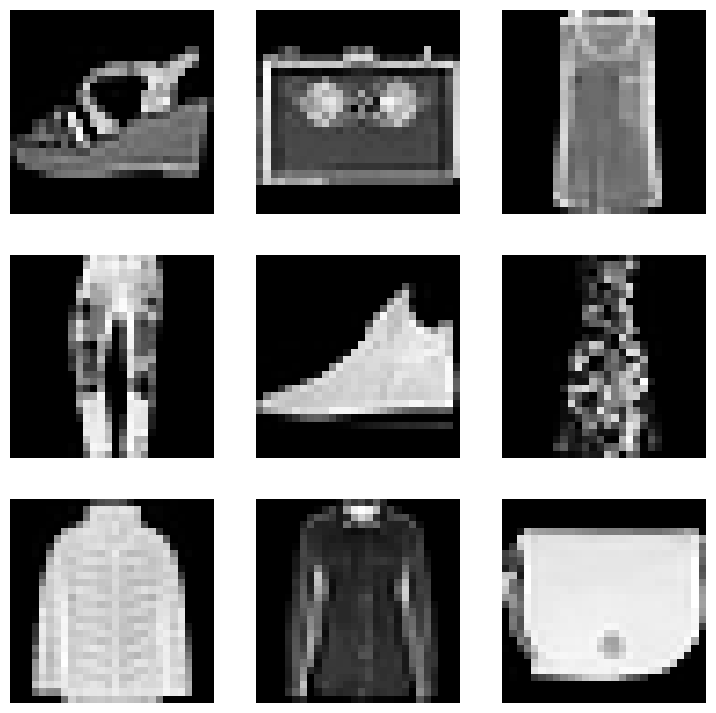

In [6]:
import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize=(9, 9))

# Choose 9 samples out of 60K available in the train set
rndSamples = np.random.choice(60000, 9)

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[rndSamples[i]], cmap="Greys_r")
    plt.axis('off')

plt.show();

We need to preprocess the data a bit before it is suitable for using with generative modeling. First, we are going to combine our training and test data together because generative models don't work via train/test measuring classification accuracy, they measure how similar generated images are to the original, using visual perception methods such as FID/IS (Frechet Inception Distance and Inception Score.) So we really just need a big pile of images.

We also need to normalize the data; the raw pixel data is in the range 0-255, but sigmoid activation values are 0-1, so we'll scale all the pixels to 0-1 by just dividing them by 255.

And, we need to add an extra dimension since convolutional layers expect 3 channels.

In [7]:
dataset = np.concatenate([x_train, x_test], axis=0)
# Please note expand_dims converts images from 28x28 to 28x28x1
# Since convolutional layers expect 3 channels
dataset = np.expand_dims(dataset, -1).astype("float32") / 255

## Custom Sampling Layer ##

Our encoder is trying to learn a probability distribution z given data X. The distribution is defined by Mu and Sigma.

Then, the decoder samples randomly from the z distribution.

The problem is that the random sampling is not differentiable, which is needed for backpropagation training. But by introducing a parameter Epsilon we make it a deterministic, differentiable operation.

In [8]:
from tensorflow import keras
from tensorflow.keras import layers


# Create a sampling layer
class SamplingLayer(layers.Layer):
  """Reparameterization Trick z = mu + sigma * epsilon"""

  def call(self, inputs):
    zMean, zLogVar = inputs
    batch = tf.shape(zMean)[0]
    dim = tf.shape(zMean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return zMean + tf.exp(0.5 * zLogVar) * epsilon

## Encoder / Decoder ##

Our encoder uses Keras functional API's to create a non-sequential model, as we need to output two values in parallel (mean and variance.)

In [9]:
def buildEncoder(latentDim, encoderInputs):

  # Given a batch of images the convolutional block extracts the features
  l1 = keras.models.Sequential([
    layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2D(64, 3, activation="relu", strides=2, padding="same"),
    layers.Flatten(),
    layers.Dense(256, activation="relu")
  ])

  # pass the inputs through the convolutional block
  x = l1(encoderInputs)

  # a dedicated layer to learn mean in parallel
  zMean = layers.Dense(latentDim, name="z_mean")(x)

  # a dedicated layer to learn variance in parallel
  zLogVar = layers.Dense(latentDim, name="z_log_var")(x)

  # now the reparametrization trick to find z as defined by mean and variance
  z = SamplingLayer()([zMean, zLogVar])

  # the actual model which takes the images as input and returns mean, variance, and distribution
  # please note the zMean and zLogVar are not the final output of the encoder, but
  # they are used in the Kullback-Leibler Divergence Loss (explained below)
  return keras.Model(encoderInputs, [zMean, zLogVar, z], name="encoder")


# trigger the function to actually build the model
encoderInputs = keras.Input(shape=(28, 28, 1))
encoder = buildEncoder(2, encoderInputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 256)          878144      ['input_1[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 2)            514         ['sequential[0][0]']             
                                                                                                  
 z_log_var (Dense)              (None, 2)            514         ['sequential[0][0]']             
                                                                                            

And now we'll implement the decoder in a similar fashion. Note the use of Conv2DTranspose instead of Conv2D; we use the transpose convolution to generate images going from lower resolutions to higher ones. That's the real heart of this technique.

In [10]:
def buildDecoder(latentInputs):

  l1 = keras.models.Sequential([
    layers.Dense(7*7*64, activation="relu", input_shape=(latentInputs.shape[1],)),
    layers.Reshape((7,7,64)),
    layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")
  ])

  return keras.Model(latentInputs, l1(latentInputs), name="decoder")

# build the actual model
latentInputs = keras.Input(shape=(2,))
decoder = buildDecoder(latentInputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         157633    
                                                                 
Total params: 157,633
Trainable params: 157,633
Non-trainable params: 0
_________________________________________________________________


## Loss Functions ##

VAE has TWO loss functions! First is the reconstruction loss, which penalizes images that are not similar to the original images.

In [11]:
def reconstructionLoss(data, reconstructed):
  return tf.reduce_mean(
      tf.reduce_sum(
          keras.losses.binary_crossentropy(data, reconstructed),
          axis=(1, 2)
      )
  )

Next we have the Kullback-Liebler Divergence loss function, also called Earth Mover loss from the analogy of figuring out how much dirt needs to be moved to transform the shape of the UK to the shape of the US.

What it really does is measure the distance between two probability distributions. It penalizes the model if it learns a probability distribution "z" that is different from the original probability distribution of the data "X".

Mathematically it is the same thing as cross-entropy - entropy, which means it works well for backpropagation and log-likelihood minimization.

In [12]:
def klDivergenceLoss(zMean, zLogVar):
  return tf.reduce_mean(
      tf.reduce_sum(
          -0.5 * (1 + zLogVar - tf.square(zMean) - tf.exp(zLogVar)),
          axis=1
      )
  )

So now we'll combine these into the total loss function, which just weights them and sums them up. Think of that weight (alpha) as another hyperparameter you can tune.

In [13]:
def calcTotalLoss(data, reconstructed, zMean, zLogVar):
  loss1 = reconstructionLoss(data, reconstructed)
  loss2 = klDivergenceLoss(zMean, zLogVar)
  klWeight = 3.0
  return  loss1, loss2, loss1 + klWeight * loss2

## Overriding train_step ##

Since we are using a custom loss function on mu and sigma, we need to override how the loss is calculated. We need to compare X_original and X_reconstructed at the same time while calculating the Kullback-Liebler (KL) loss.

In [14]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    # register total loss as an observable metric in the model training history
    self.totalLossTracker = keras.metrics.Mean(name="total_loss")
    self.ceLossTracker = keras.metrics.Mean(name="ce_loss")
    self.klLossTracker = keras.metrics.Mean(name="kl_loss")
    
  # This are all observable metrics 
  @property
  def metrics(self):
    return [
        self.totalLossTracker,
        self.ceLossTracker,
        self.klLossTracker
    ]

  # Now calculate loss + calculate gradients + update weights
  def train_step(self, data):
    # Gradient tape is a recording of all gradients for the trainable 
    # weights that need to be updated
    with tf.GradientTape() as tape:
        # forward path
        zMean, zLogVar, z = self.encoder(data)
        reconstruction = self.decoder(z)
        ceLoss, klLoss, totalLoss = calcTotalLoss(data, reconstruction, zMean, zLogVar)
    # backward path
    grads = tape.gradient(totalLoss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    # keep track of loss
    self.totalLossTracker.update_state(totalLoss)
    self.ceLossTracker.update_state(ceLoss)
    self.klLossTracker.update_state(klLoss)

    # return the loss for history object
    return {
        "total_loss": self.totalLossTracker.result(),
        "ce_loss": self.ceLossTracker.result(),
        "kl_loss": self.klLossTracker.result()
    }

## Train the VAE! ##

In [15]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
history = vae.fit(dataset, epochs=32, batch_size=128)

Epoch 1/32
547/547 [==============================] - 25s 22ms/step - total_loss: 312.2023 - ce_loss: 300.8364 - kl_loss: 3.7887
Epoch 2/32
547/547 [==============================] - 12s 22ms/step - total_loss: 278.0466 - ce_loss: 264.2816 - kl_loss: 4.5883
Epoch 3/32
547/547 [==============================] - 12s 22ms/step - total_loss: 274.8952 - ce_loss: 260.8509 - kl_loss: 4.6814
Epoch 4/32
547/547 [==============================] - 12s 22ms/step - total_loss: 273.2750 - ce_loss: 258.9672 - kl_loss: 4.7693
Epoch 5/32
547/547 [==============================] - 12s 22ms/step - total_loss: 272.2024 - ce_loss: 257.7289 - kl_loss: 4.8245
Epoch 6/32
547/547 [==============================] - 12s 22ms/step - total_loss: 271.3758 - ce_loss: 256.7149 - kl_loss: 4.8869
Epoch 7/32
547/547 [==============================] - 12s 23ms/step - total_loss: 270.8427 - ce_loss: 256.0399 - kl_loss: 4.9342
Epoch 8/32
547/547 [==============================] - 12s 23ms/step - total_loss: 270.2407 - ce_l

Let's visualize how the loss functions changed over each epoch; this can inform at what point it makes sense to stop.

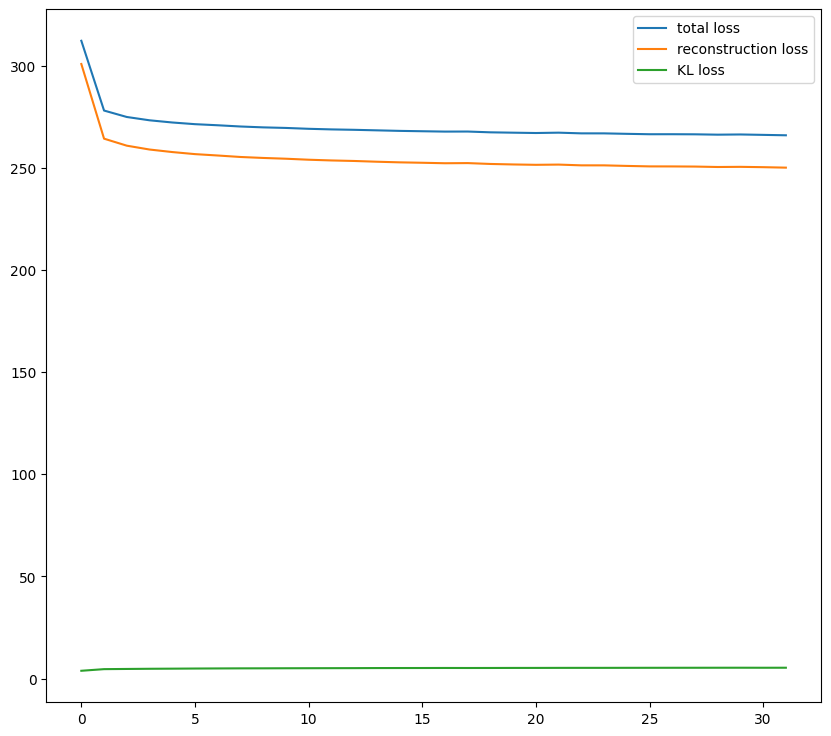

In [16]:
plt.figure(figsize=(10, 9))
plt.plot(history.history.get('total_loss'), label="total loss")
plt.plot(history.history.get('ce_loss'), label="reconstruction loss")
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

Let's zoom into the KL loss so we can see it better:

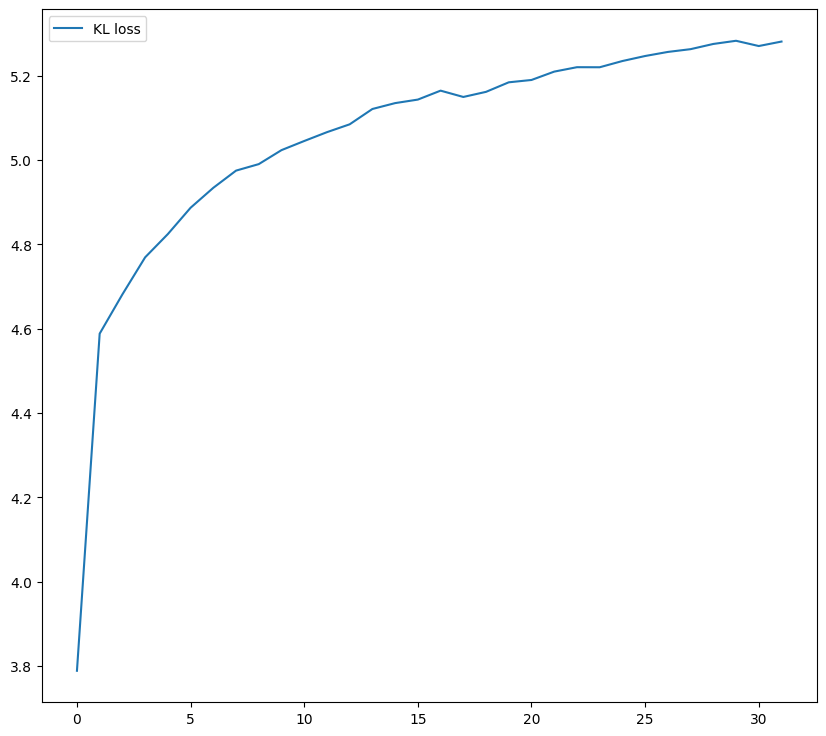

In [17]:
plt.figure(figsize=(10, 9))
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

# Explore the results ##

Let's use a mean (mu) of 1 and variance (sigma) of 2 (just a guess to start with). Play around with this, try different values to get different types of objects (shirts, bags, etc.)

1/1 [==============================] - 0s 145ms/step


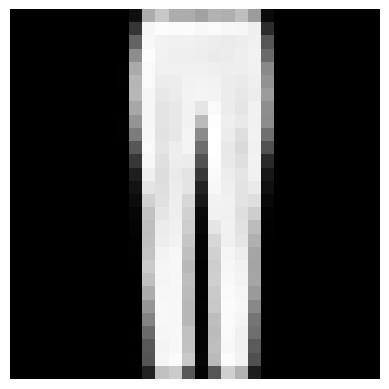

In [18]:
synth = vae.decoder.predict([[1, 2]])
plt.axis('off')
plt.imshow(synth.reshape((28,28)), cmap="Greys_r");

Let's generate 256 images entirely at random. All we have to do is guess the Z distribution (defined by mu, sigma). Don't worry, we will get to a systematic method to determine the mu and sigma for each category.

8/8 [==============================] - 0s 6ms/step


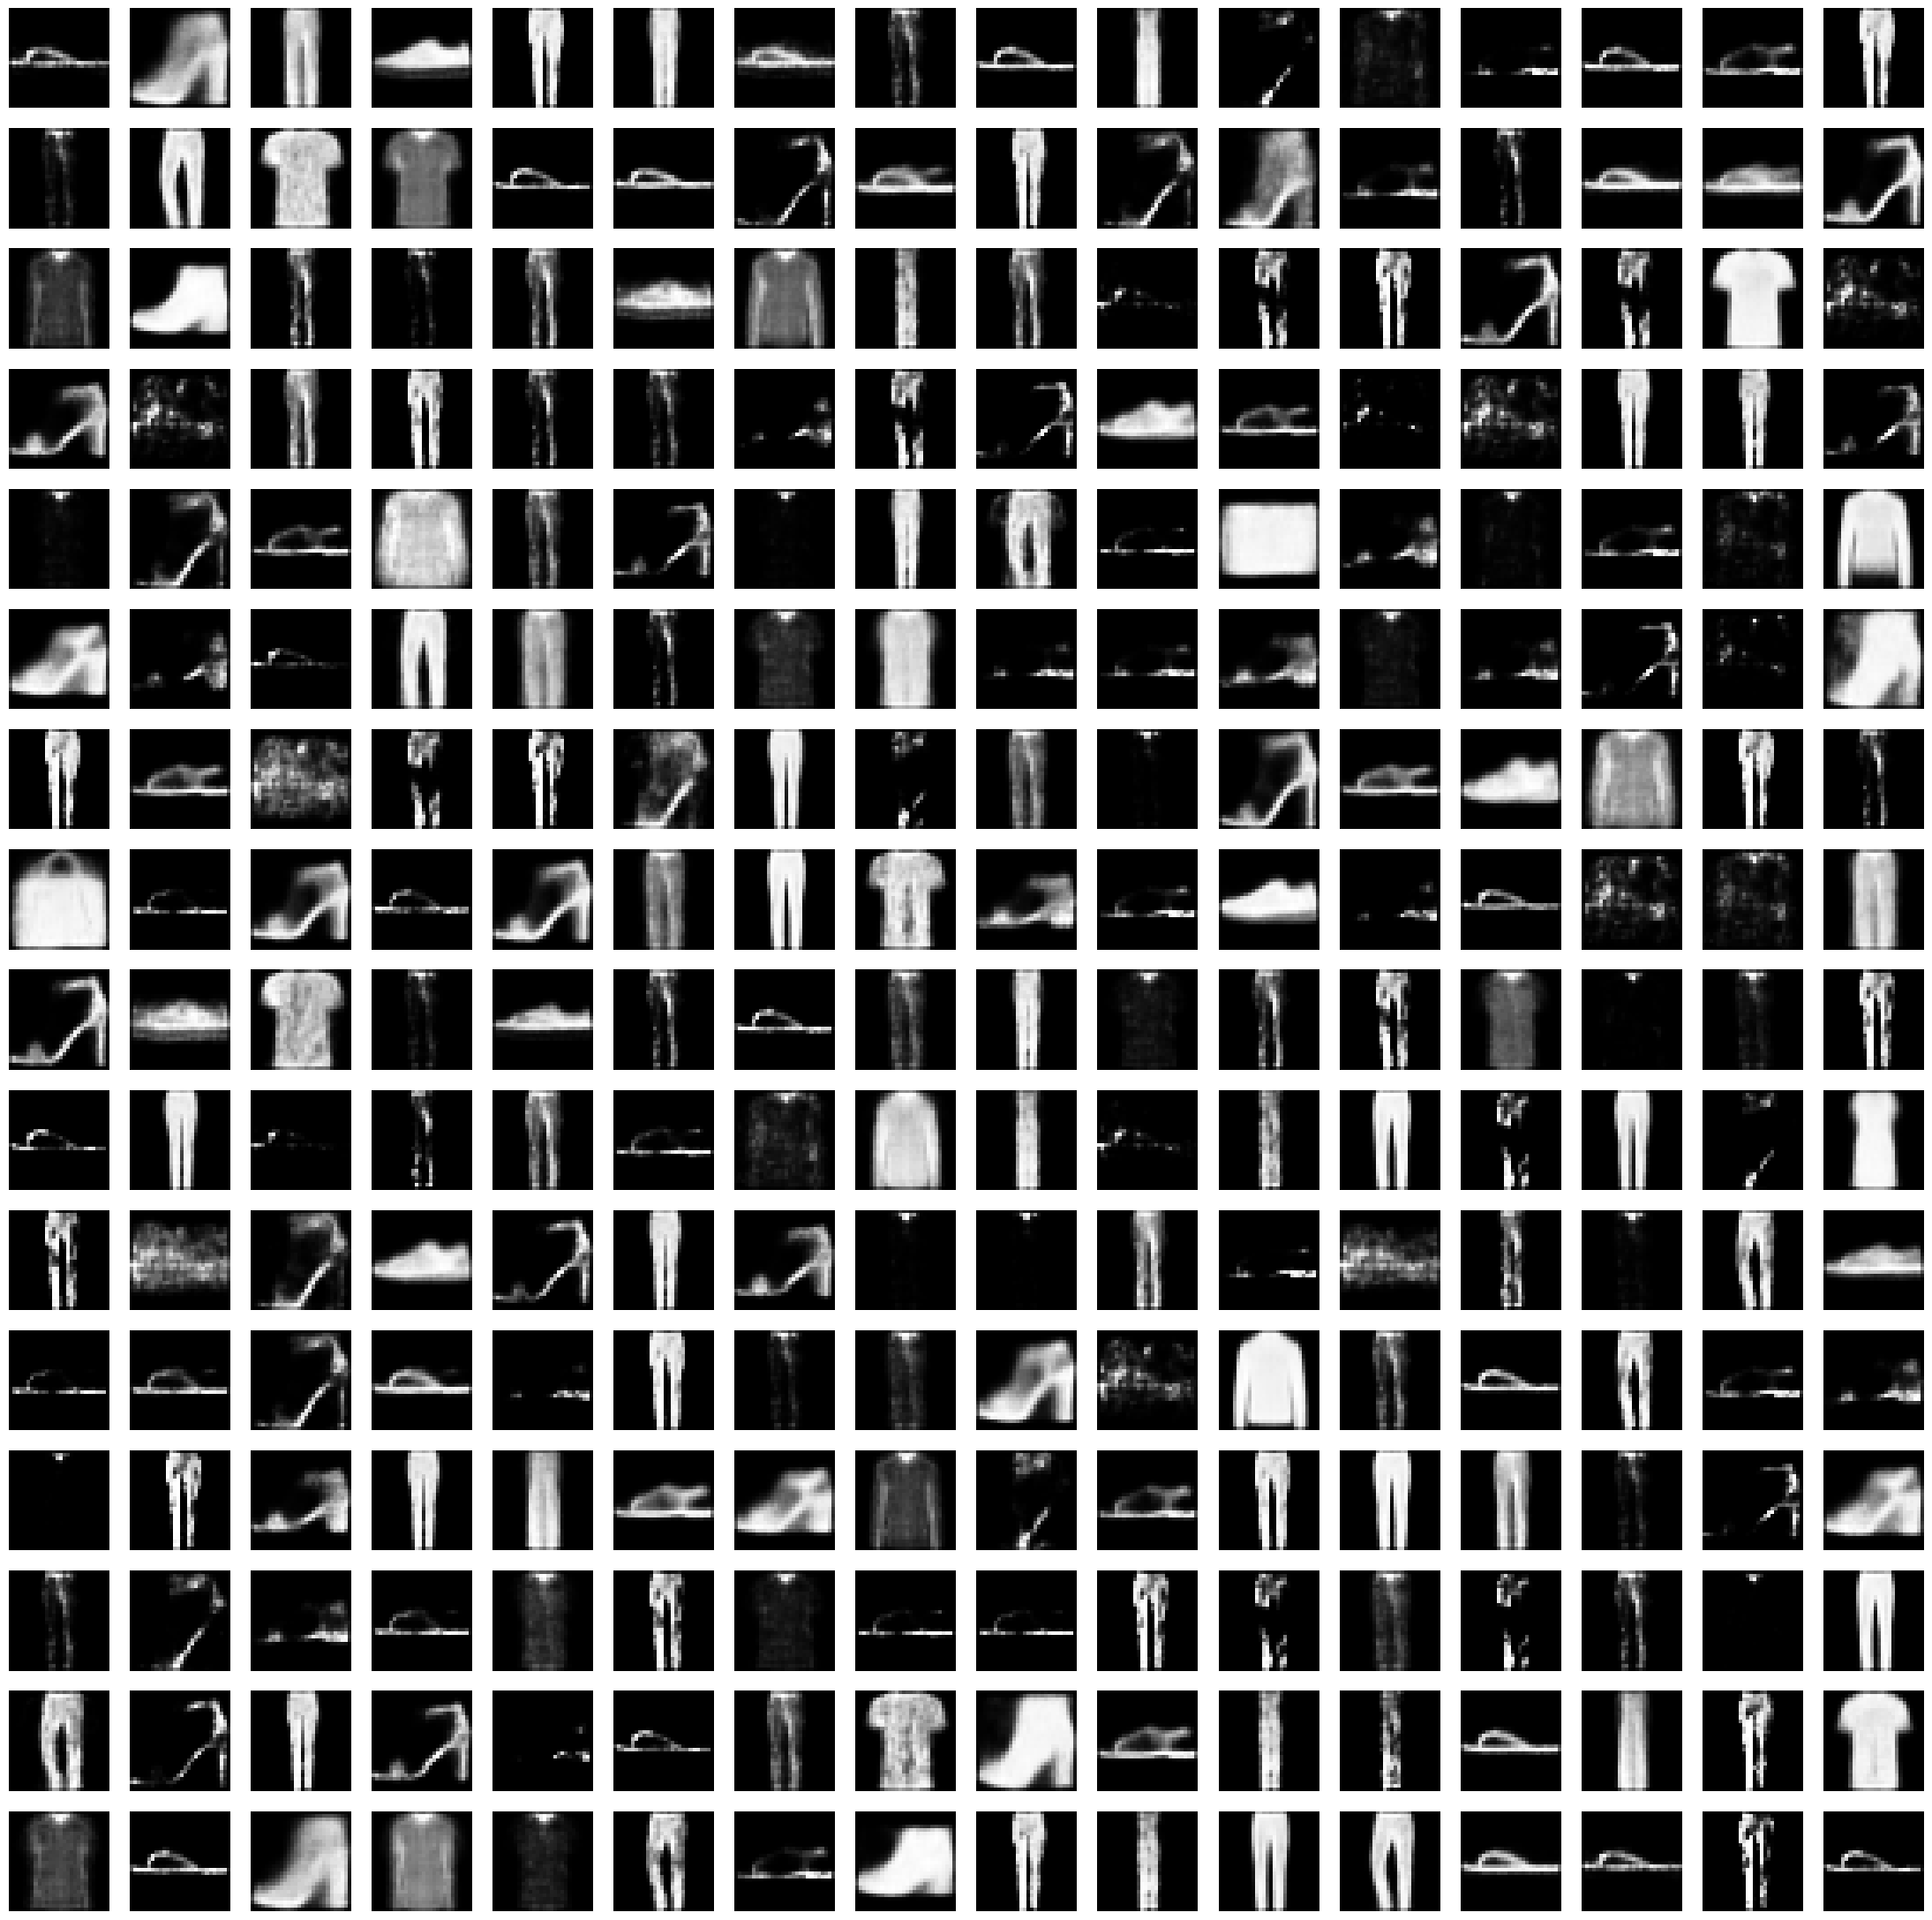

In [19]:
z = np.random.normal(loc=0, scale=4, size=(256,2))
synth = vae.decoder.predict(z)

plt.figure(figsize=(28,28))

for i in range(256):
    plt.subplot(16,16,i+1)
    plt.imshow(synth[i].reshape((28,28)), cmap="Greys_r")
    plt.axis('off')

plt.show();

As promised, we can find the mapping of mu and sigma for each category. Just map an image from each category through the encoder and observe the output. Then use those outputs to conditionally instruct the decoder to sample from a particular category. This isn't a guaranteed solution though - for concrete results look up "Conditional Variational AutoEncoders".

In [20]:
idx = 1280
batch = np.expand_dims(x_train[idx], axis=0)
batchOfImages = np.expand_dims(batch, axis=-1).astype("float32") / 255
print(batchOfImages.shape)
# obtain z(mu,sigma) for the given image
_, _, z = vae.encoder.predict(batchOfImages)

# now reconstruct a similar image
synth = vae.decoder.predict([z])

z

(1, 28, 28, 1)
1/1 [==============================] - 0s 87ms/step


array([[-0.07663418,  1.4195367 ]], dtype=float32)

Note that the reconstructed image could be different from the original, depending on how long the model has been trained and whether it has reached a global minima.

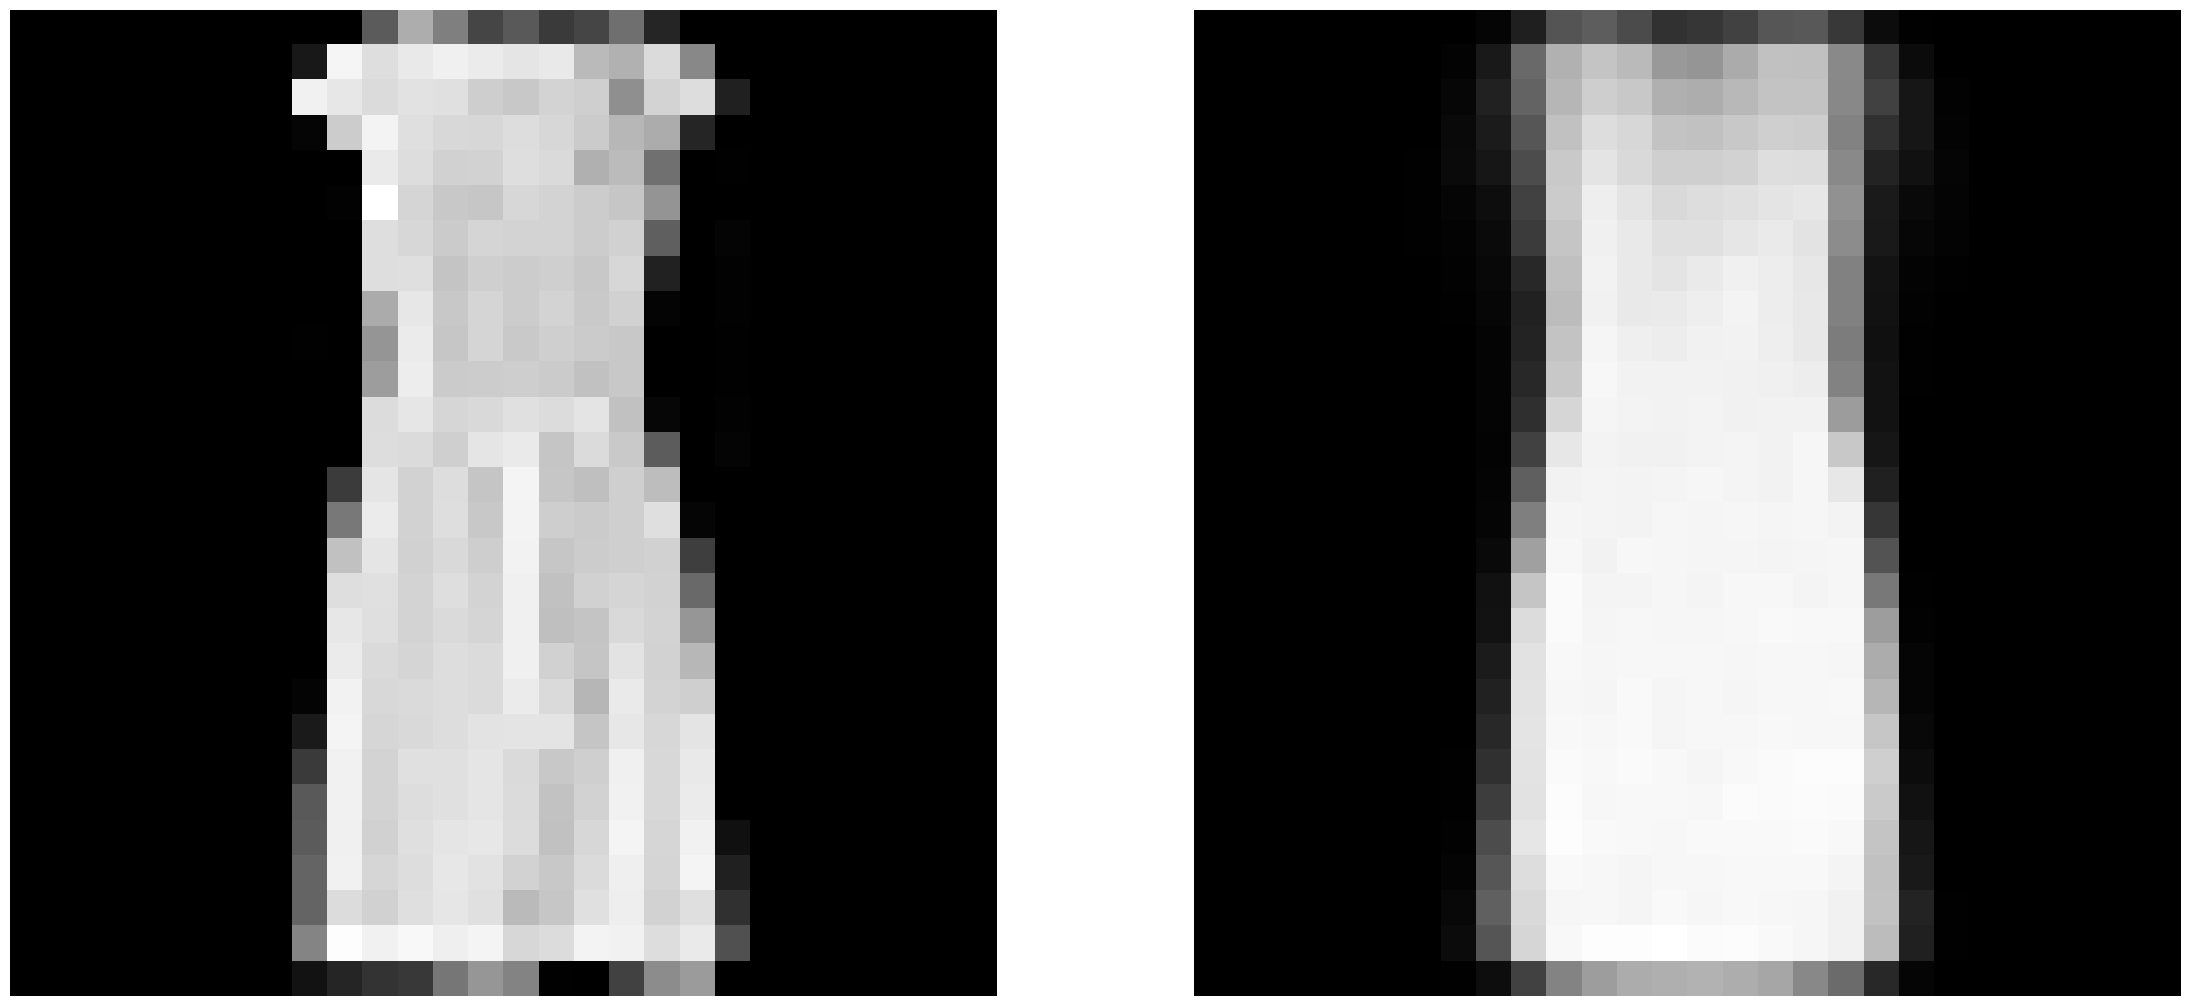

In [21]:
plt.figure(figsize=(28, 28))

# original image
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(x_train[idx], cmap="Greys_r")


# reconstructed
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(synth[0].reshape((28,28)), cmap="Greys_r")
plt.show();

2188/2188 [==============================] - 3s 2ms/step


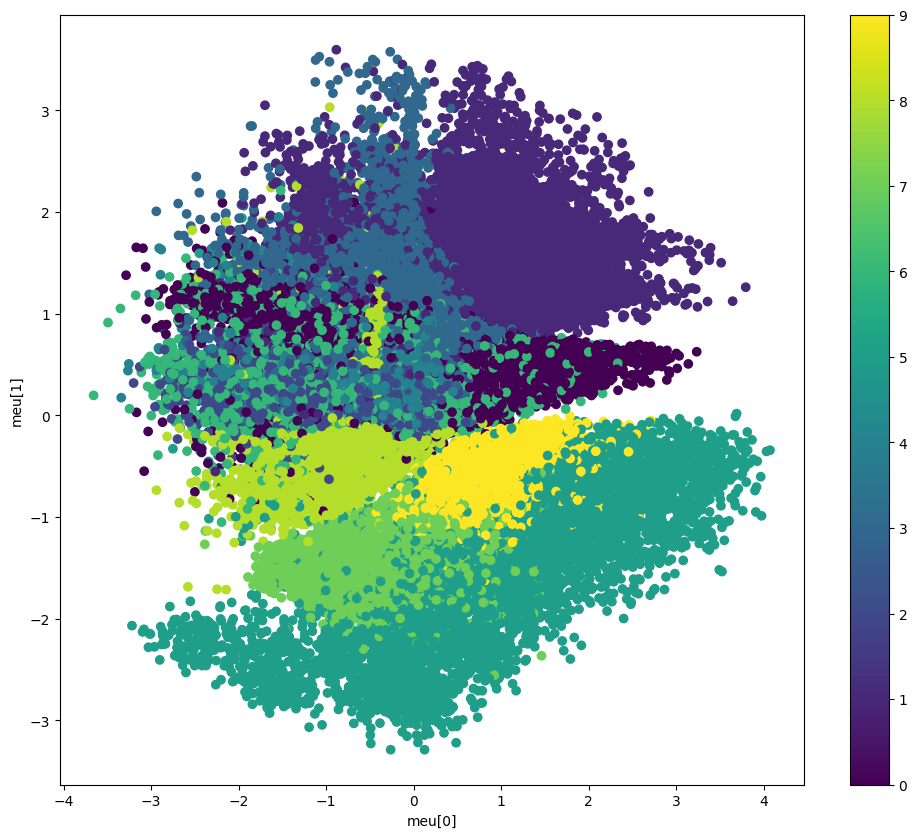

In [22]:
"""
VAE can be used in unsupervised learning of large text or unlabeled images corpus
to cluster the samples into categories
"""
labels = np.concatenate([y_train, y_test], axis=0)
meu, _, _ = vae.encoder.predict(dataset)
plt.figure(figsize=(12, 10))
plt.scatter(meu[:, 0], meu[:, 1], c=labels)
plt.colorbar()
plt.xlabel("meu[0]")
plt.ylabel("meu[1]")
plt.show();